In [75]:
import nltk                         # NLP toolbox
from os import getcwd
import pandas as pd                 # Library for Dataframes 
from nltk.corpus import twitter_samples 
import matplotlib.pyplot as plt     # Library for visualization
import numpy as np                  # Library for math functions
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

from utils import process_tweet, build_freqs # Our functions for NLP

In [2]:
%load_ext autoreload
%autoreload 2

We assume that the tweets dataset has already been downloaded

In [10]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

tweets = np.array(all_positive_tweets + all_negative_tweets) ## Concatenate the lists. 
labels = np.append(np.ones(len(all_positive_tweets)), np.zeros(len(all_negative_tweets)), axis = 0)

Below are the emoticons associated with positive and negative sentiment

In [4]:
from utils import emoticons

In [7]:
emoticons.keys()

dict_keys(['positive', 'negative'])

My guess is that these are sufficient to have a good prediction on the sentiment of the tweet, regardless of the words contained in the tweet.

## Processing all tweets

In the following, we tokenize each tweet then check whether it contains a negative or a positive emoticon (or both)

In [12]:
df_tweets = pd.DataFrame(zip(labels, tweets), columns = ['label', 'tweet'])

In [13]:
df_tweets.head()

,label,tweet
0,1.0,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,1.0,@Lamb2ja Hey James! How odd :/ Please call our...
2,1.0,@DespiteOfficial we had a listen last night :)...
3,1.0,@97sides CONGRATS :)
4,1.0,yeaaaah yippppy!!! my accnt verified rqst has...


We first process the tweets

In [14]:
remove_emoticons = False
df_tweets['tokens'] = df_tweets.tweet.apply(lambda x: process_tweet(x, remove_emoticons))

## Features engineering

### Number of normalized tokens per tweet

Then we create a feature on the number of obtained tokens for each tweet

In [17]:
df_tweets['n_tokens'] = df_tweets.tokens.apply(lambda x: len(x))

In [18]:
df_tweets.head()

,label,tweet,tokens,n_tokens
0,1.0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,"[followfriday, top, engag, member, commun, wee...",7
1,1.0,@Lamb2ja Hey James! How odd :/ Please call our...,"[hey, jame, odd, :/, pleas, call, contact, cen...",14
2,1.0,@DespiteOfficial we had a listen last night :)...,"[listen, last, night, :), bleed, amaz, track, ...",8
3,1.0,@97sides CONGRATS :),"[congrat, :)]",2
4,1.0,yeaaaah yippppy!!! my accnt verified rqst has...,"[yeaaah, yipppi, accnt, verifi, rqst, succeed,...",15


The positive and negative tweets have roughly the same mean number of tokens

In [22]:
df_tweets.groupby('label')['n_tokens'].agg(['mean', 'std'])

,mean,std
label,,
0.0,6.7402,4.184042
1.0,6.7602,3.943223


<AxesSubplot:title={'center':'n_tokens'}, xlabel='[label]'>

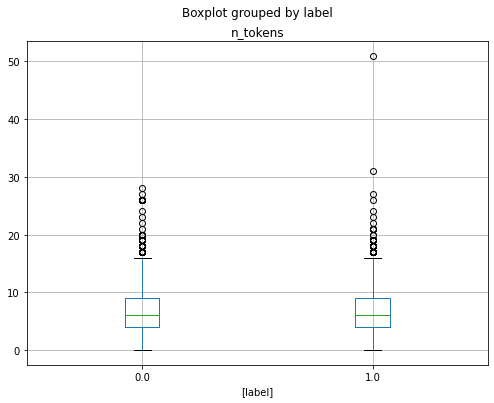

In [33]:
df_tweets[['label', 'n_tokens']].boxplot(by = 'label', figsize = (8, 6))

### Urls in tweets

Let's create an additional feature reflecting whether the tweet contains an url or not

In [24]:
df_tweets['has_url'] = df_tweets.tweet.apply(lambda x: 'http' in x)

In [25]:
df_tweets.head()

,label,tweet,tokens,n_tokens,has_url
0,1.0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,"[followfriday, top, engag, member, commun, wee...",7,False
1,1.0,@Lamb2ja Hey James! How odd :/ Please call our...,"[hey, jame, odd, :/, pleas, call, contact, cen...",14,False
2,1.0,@DespiteOfficial we had a listen last night :)...,"[listen, last, night, :), bleed, amaz, track, ...",8,False
3,1.0,@97sides CONGRATS :),"[congrat, :)]",2,False
4,1.0,yeaaaah yippppy!!! my accnt verified rqst has...,"[yeaaah, yipppi, accnt, verifi, rqst, succeed,...",15,False


Positive tweets hav twice as much url but the difference is not statistically significant

In [26]:
df_tweets.groupby('label')['has_url'].agg(['mean', 'std'])

,mean,std
label,,
0.0,0.1112,0.314411
1.0,0.2218,0.415499


### Has positive or negative emoticons

In [27]:
df_tweets['has_positive_emo'] = df_tweets.tokens.apply(lambda x: not set(emoticons['positive']).isdisjoint(x))
df_tweets['has_negative_emo'] = df_tweets.tokens.apply(lambda x: not set(emoticons['negative']).isdisjoint(x))

In [28]:
df_tweets.head()

,label,tweet,tokens,n_tokens,has_url,has_positive_emo,has_negative_emo
0,1.0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,"[followfriday, top, engag, member, commun, wee...",7,False,True,False
1,1.0,@Lamb2ja Hey James! How odd :/ Please call our...,"[hey, jame, odd, :/, pleas, call, contact, cen...",14,False,True,False
2,1.0,@DespiteOfficial we had a listen last night :)...,"[listen, last, night, :), bleed, amaz, track, ...",8,False,True,False
3,1.0,@97sides CONGRATS :),"[congrat, :)]",2,False,True,False
4,1.0,yeaaaah yippppy!!! my accnt verified rqst has...,"[yeaaah, yipppi, accnt, verifi, rqst, succeed,...",15,False,True,False


In [30]:
df_tweets.groupby('label')[['has_positive_emo', 'has_negative_emo']].mean()

,has_positive_emo,has_negative_emo
label,,
0.0,0.0060,0.9852
1.0,0.9586,0.0002


## Sentiment Analysis

We'll predict the sentiment of the tweet using these two approaches
- Predicting negative sentiment if the tweet contains a negative emoticons, and positive otherwise
- Using a logistic regression bases on the two features approach presented in the course : the first feature is the total sum of frequencies of each token in the positive tweets and the second feeature is the total sum of frequencies of each token in the negative tweets

First we split the data into training and testing sets

In [44]:
df_train = pd.concat([df_tweets.iloc[:4000, :], df_tweets.iloc[5000:9000, :]])
df_test = df_tweets.drop(df_train.index)

### Sentiment Analysis based on emoticons

In [46]:
y_pred_train_emo = 1- df_train.has_negative_emo
y_pred_test_emo = 1 - df_test.has_negative_emo

In [52]:
confusion_matrix(df_train.label, y_pred_train_emo, labels = [0, 1]), accuracy_score(df_train.label, y_pred_train_emo)

(array([[3936,   64],
        [   1, 3999]]),
 0.991875)

In [53]:
confusion_matrix(df_test.label, y_pred_test_emo, labels = [0, 1]), accuracy_score(df_test.label, y_pred_test_emo)

(array([[ 990,   10],
        [   0, 1000]]),
 0.995)

### Sentiment Analysis based on the frequency table (with emoticons)

Here we need to first calculate the frequency table based on the train set only then derive the training matrix

#### Frequency table

In [61]:
freqs = {}
for i in range(df_train.shape[0]):
    row = df_train.iloc[i, :]
    for token in row.tokens:
        if token in freqs:
            freqs[token] = [freqs[token][0] + row.label, freqs[token][1] + 1 - row.label]
        else:
            freqs[token] = [row.label, 1 - row.label]
# Ordering by the most frequent token
freqs = dict(sorted(freqs.items(), key = lambda item: sum(item[1]), reverse = True))

In [62]:
freqs

{':(': [1.0, 3663.0],
 ':)': [2847.0, 2.0],
 'thank': [504.0, 94.0],
 'follow': [319.0, 245.0],
 ':-)': [543.0, 0.0],
 '...': [227.0, 282.0],
 ':d': [498.0, 0.0],
 'love': [336.0, 128.0],
 "i'm": [140.0, 266.0],
 ':-(': [0.0, 378.0],
 'like': [187.0, 182.0],
 'get': [164.0, 181.0],
 'pleas': [80.0, 243.0],
 'day': [187.0, 114.0],
 'go': [120.0, 181.0],
 'u': [136.0, 151.0],
 'good': [191.0, 83.0],
 'see': [156.0, 104.0],
 'miss': [17.0, 239.0],
 'want': [69.0, 185.0],
 'know': [120.0, 110.0],
 'time': [100.0, 125.0],
 '♛': [0.0, 210.0],
 '》': [0.0, 210.0],
 'one': [90.0, 117.0],
 'hope': [113.0, 91.0],
 'work': [88.0, 102.0],
 '..': [100.0, 89.0],
 'much': [73.0, 116.0],
 'look': [109.0, 79.0],
 'hi': [154.0, 28.0],
 'happi': [161.0, 18.0],
 "can't": [31.0, 148.0],
 'today': [86.0, 88.0],
 'back': [74.0, 98.0],
 'realli': [66.0, 103.0],
 'feel': [33.0, 131.0],
 'make': [69.0, 90.0],
 'new': [111.0, 43.0],
 'great': [134.0, 15.0],
 'need': [62.0, 86.0],
 'got': [57.0, 90.0],
 'im': [38.

#### Feature matrices

In [105]:
def buildTokensFeatures(tokens, freqs):
    sums = [1, 0, 0]
    for token in tokens:
        if token in freqs:
            sums[1] += freqs[token][0]
            sums[2] += freqs[token][1]
    return sums

In [74]:
X_train = list(df_train.tokens.apply(lambda x: buildTokensFeatures(x, freqs)))
y_train = df_train.label

In [100]:
X_train[-1]

[1, 189.0, 3974.0]

In [77]:
X_test = list(df_test.tokens.apply(lambda x: buildTokensFeatures(x)))
y_test = df_test.label

#### Training the logistic regression

In [94]:
clf = LogisticRegression(random_state = 0, fit_intercept = False, penalty = 'none')
clf.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, penalty='none', random_state=0)

In [98]:
clf.coef_, clf.intercept_

(array([[ 0.99990786,  0.00903442, -0.01027012]]), array([0.]))

In [96]:
clf.score(X_train, y_train)

0.990375

In [97]:
clf.score(X_test, y_test)

0.9915

### Sentiment Analysis based on the freqs table (without emoticons)

Here we need to redo the processing to exclude the emoticons

In [102]:
df_tweets_noemo = df_tweets[['label', 'tweet']].copy()

In [103]:
remove_emoticons = True
df_tweets_noemo['tokens'] = df_tweets_noemo.tweet.apply(lambda x: process_tweet(x, remove_emoticons))

In [104]:
df_train_noemo = pd.concat([df_tweets_noemo.iloc[:4000, :], df_tweets_noemo.iloc[5000:9000, :]])
df_test_noemo = df_tweets_noemo.drop(df_train_noemo.index)

In [255]:
df_train.label.unique()

array([1., 0.])

In [256]:
freqs_noemo = {}
for i in range(df_train_noemo.shape[0]):
    row = df_train_noemo.iloc[i, :]
    for token in row.tokens:
        if token in freqs_noemo:
            freqs_noemo[token] = [freqs_noemo[token][0] + int(row.label), freqs_noemo[token][1] + 1 - int(row.label)]
        else:
            freqs_noemo[token] = [int(row.label), 1 - int(row.label)]
# Ordering by the most frequent token
freqs_noemo = dict(sorted(freqs_noemo.items(), key = lambda item: sum(item[1]), reverse = True))

In [257]:
freqs_noemo

{'thank': [504, 94],
 'follow': [319, 245],
 '...': [227, 282],
 ':d': [498, 0],
 'love': [336, 128],
 "i'm": [140, 266],
 'like': [187, 182],
 'get': [164, 181],
 'pleas': [80, 243],
 'day': [187, 114],
 'go': [120, 181],
 'u': [136, 151],
 'good': [191, 83],
 'see': [156, 104],
 'miss': [17, 239],
 'want': [69, 185],
 'know': [120, 110],
 'time': [100, 125],
 '♛': [0, 210],
 '》': [0, 210],
 'one': [90, 117],
 'hope': [113, 91],
 'work': [88, 102],
 '..': [100, 89],
 'much': [73, 116],
 'look': [109, 79],
 'hi': [154, 28],
 'happi': [161, 18],
 "can't": [31, 148],
 'today': [86, 88],
 'back': [74, 98],
 'realli': [66, 103],
 'feel': [33, 131],
 'make': [69, 90],
 'new': [111, 43],
 'great': [134, 15],
 'need': [62, 86],
 'got': [57, 90],
 'im': [38, 108],
 'still': [37, 104],
 'come': [63, 72],
 'sorri': [13, 117],
 'us': [91, 33],
 'would': [70, 54],
 'oh': [44, 78],
 'week': [72, 47],
 'well': [66, 49],
 'think': [48, 64],
 "i'll": [73, 36],
 'sleep': [35, 71],
 'sad': [5, 100],
 'f

In [107]:
X_train_noemo = list(df_train_noemo.tokens.apply(lambda x: buildTokensFeatures(x, freqs_noemo)))
y_train_noemo = df_train_noemo.label

In [108]:
X_train_noemo[:10]

[[1, 173.0, 59.0],
 [1, 726.0, 442.0],
 [1, 158.0, 113.0],
 [1, 15.0, 2.0],
 [1, 272.0, 223.0],
 [1, 108.0, 117.0],
 [1, 1087.0, 536.0],
 [1, 315.0, 274.0],
 [1, 628.0, 189.0],
 [1, 161.0, 112.0]]

In [109]:
X_test_noemo = list(df_test_noemo.tokens.apply(lambda x: buildTokensFeatures(x, freqs_noemo)))
y_test_noemo = df_test_noemo.label

In [110]:
clf_noemo = LogisticRegression(random_state = 0, fit_intercept = False, penalty = 'none')
clf_noemo.fit(X_train_noemo, y_train_noemo)

LogisticRegression(fit_intercept=False, penalty='none', random_state=0)

In [114]:
clf_noemo.score(X_train_noemo, y_train_noemo)

0.750625

In [115]:
clf_noemo.score(X_test_noemo, y_test_noemo)

0.714

In [116]:
clf_noemo.coef_

array([[-0.12440979,  0.00843971, -0.00884083]])

### Frequencies baased on Scikit-learn CountVectorizer

In [120]:
from sklearn.feature_extraction.text import CountVectorizer

In [152]:
vocabulary = set(np.hstack(df_train.tokens.values))
len(vocabulary)

9085

In [197]:
cv = CountVectorizer(vocabulary = vocabulary, analyzer = 'word')

In [203]:
X = cv.fit_transform(df_train.tokens.apply(lambda x: ' '.join(x))).toarray()

In [296]:
cv_df = pd.DataFrame(X, columns = cv.get_feature_names())
cv_df['label'] = df_train.label.values
cv_df.head()

,(-:,(:,):,--->,-->,->,.\n.,.\n.\n.,. .,. . .,...,😴,😵,🙅,🙈,🙏🏻,🚂,🚖,🚙,󾆖,󾌴
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
cv_df.label.count()

8000

In [298]:
cv_df.groupby('label').sum().T.sort_values(by = 1.0, ascending = False)

label,0.0,1.0
thank,94,504
love,128,336
follow,245,319
good,83,192
day,114,188
...,...,...
k,0,0
juudiciari,1,0
justi̇n,0,0
justinbieb,4,0
